In [100]:
import gc
import os
import random
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

In [101]:
SEED = 11
FOLDS = 5
ESTIMATORS = 100
SCORING = make_scorer(roc_auc_score, greater_is_better=True, needs_proba=True, average='macro')
TARGET = 'Target'
FEATURES = [f'Var{i}' for i in range(4, 164)]

#COLUMNS = {'ID': np.int32, 'Fold': str, 'Target': np.int16, 'Var4': int}

In [102]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)


seed_everything(SEED)

In [103]:
#data = pd.read_csv(f'data/ex2.csv', index_col='ID', dtype=COLUMNS, usecols=list(COLUMNS.keys()))
data = pd.read_csv(f'data/ex2.csv', index_col='ID')
data.drop(columns='Unnamed: 0', inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13015 entries, 1 to 13015
Columns: 162 entries, Fold to Var163
dtypes: float64(19), int64(142), object(1)
memory usage: 16.2+ MB


In [104]:
train = data[data['Fold'] == 'IS'].copy()
train.drop(columns='Fold', inplace=True)
train.info(max_cols=200)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8242 entries, 1 to 8725
Data columns (total 161 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Target  8242 non-null   int64  
 1   Var4    8242 non-null   int64  
 2   Var5    8242 non-null   int64  
 3   Var6    8242 non-null   int64  
 4   Var7    8242 non-null   float64
 5   Var8    8242 non-null   int64  
 6   Var9    8242 non-null   float64
 7   Var10   8242 non-null   int64  
 8   Var11   8242 non-null   int64  
 9   Var12   8242 non-null   int64  
 10  Var13   8242 non-null   float64
 11  Var14   8242 non-null   float64
 12  Var15   8242 non-null   int64  
 13  Var16   8242 non-null   int64  
 14  Var17   8242 non-null   int64  
 15  Var18   8242 non-null   int64  
 16  Var19   8242 non-null   int64  
 17  Var20   8242 non-null   int64  
 18  Var21   8242 non-null   int64  
 19  Var22   8242 non-null   int64  
 20  Var23   8242 non-null   int64  
 21  Var24   8242 non-null   float64
 22 

In [105]:
test = data[data['Fold'] == 'OS'].copy()
test.drop(columns='Fold', inplace=True)
test.info(max_cols=200)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4773 entries, 101 to 13015
Data columns (total 161 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Target  4773 non-null   int64  
 1   Var4    4773 non-null   int64  
 2   Var5    4773 non-null   int64  
 3   Var6    4773 non-null   int64  
 4   Var7    4773 non-null   float64
 5   Var8    4773 non-null   int64  
 6   Var9    4773 non-null   float64
 7   Var10   4773 non-null   int64  
 8   Var11   4773 non-null   int64  
 9   Var12   4773 non-null   int64  
 10  Var13   4773 non-null   float64
 11  Var14   4773 non-null   float64
 12  Var15   4773 non-null   int64  
 13  Var16   4773 non-null   int64  
 14  Var17   4773 non-null   int64  
 15  Var18   4773 non-null   int64  
 16  Var19   4773 non-null   int64  
 17  Var20   4773 non-null   int64  
 18  Var21   4773 non-null   int64  
 19  Var22   4773 non-null   int64  
 20  Var23   4773 non-null   int64  
 21  Var24   4773 non-null   float64
 

In [106]:
del data
gc.collect()

116

In [107]:
train['Target'].value_counts(normalize=True)

0    0.975855
1    0.024145
Name: Target, dtype: float64

In [108]:
test['Target'].value_counts(normalize=True)

0    0.98282
1    0.01718
Name: Target, dtype: float64

In [109]:
y_train = train[TARGET]
x_train = train[FEATURES]

In [110]:
# scale_pos_weight is the ratio of number of negative class to the positive class.
model = lgb.LGBMClassifier(n_estimators=ESTIMATORS, reg_alpha=1, scale_pos_weight=49)
pipe = Pipeline([('model', model)])
param_grid = {
    'model__learning_rate': [0.01],
    'model__num_leaves': [31],
    'model__min_child_samples': [20],
    'model__colsample_bytree': [0.5]
}
# Defaults to StratifiedKFold
lgbm = GridSearchCV(pipe, cv=FOLDS, param_grid=param_grid, scoring=SCORING)
lgbm.fit(x_train, y_train)
best_score = lgbm.best_score_
best_score_std = lgbm.cv_results_['std_test_score'][lgbm.best_index_]
print(f"""best params={repr(lgbm.best_params_)}
best score={best_score:0.3f}, std={best_score_std:0.3f}
""")
res = pd.DataFrame.from_dict(lgbm.cv_results_)
res.set_index('rank_test_score', inplace=True)
res.head()

best params={'model__colsample_bytree': 0.5, 'model__learning_rate': 0.01, 'model__min_child_samples': 20, 'model__num_leaves': 31}
best score=0.664, std=0.070



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__colsample_bytree,param_model__learning_rate,param_model__min_child_samples,param_model__num_leaves,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score
rank_test_score,,,,,,,,,,,,,,,,
1,0.174756,0.013086,0.006225,0.000354,0.5,0.01,20,31,"{'model__colsample_bytree': 0.5, 'model__learn...",0.578076,0.606339,0.650348,0.766154,0.72144,0.664471,0.070182


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

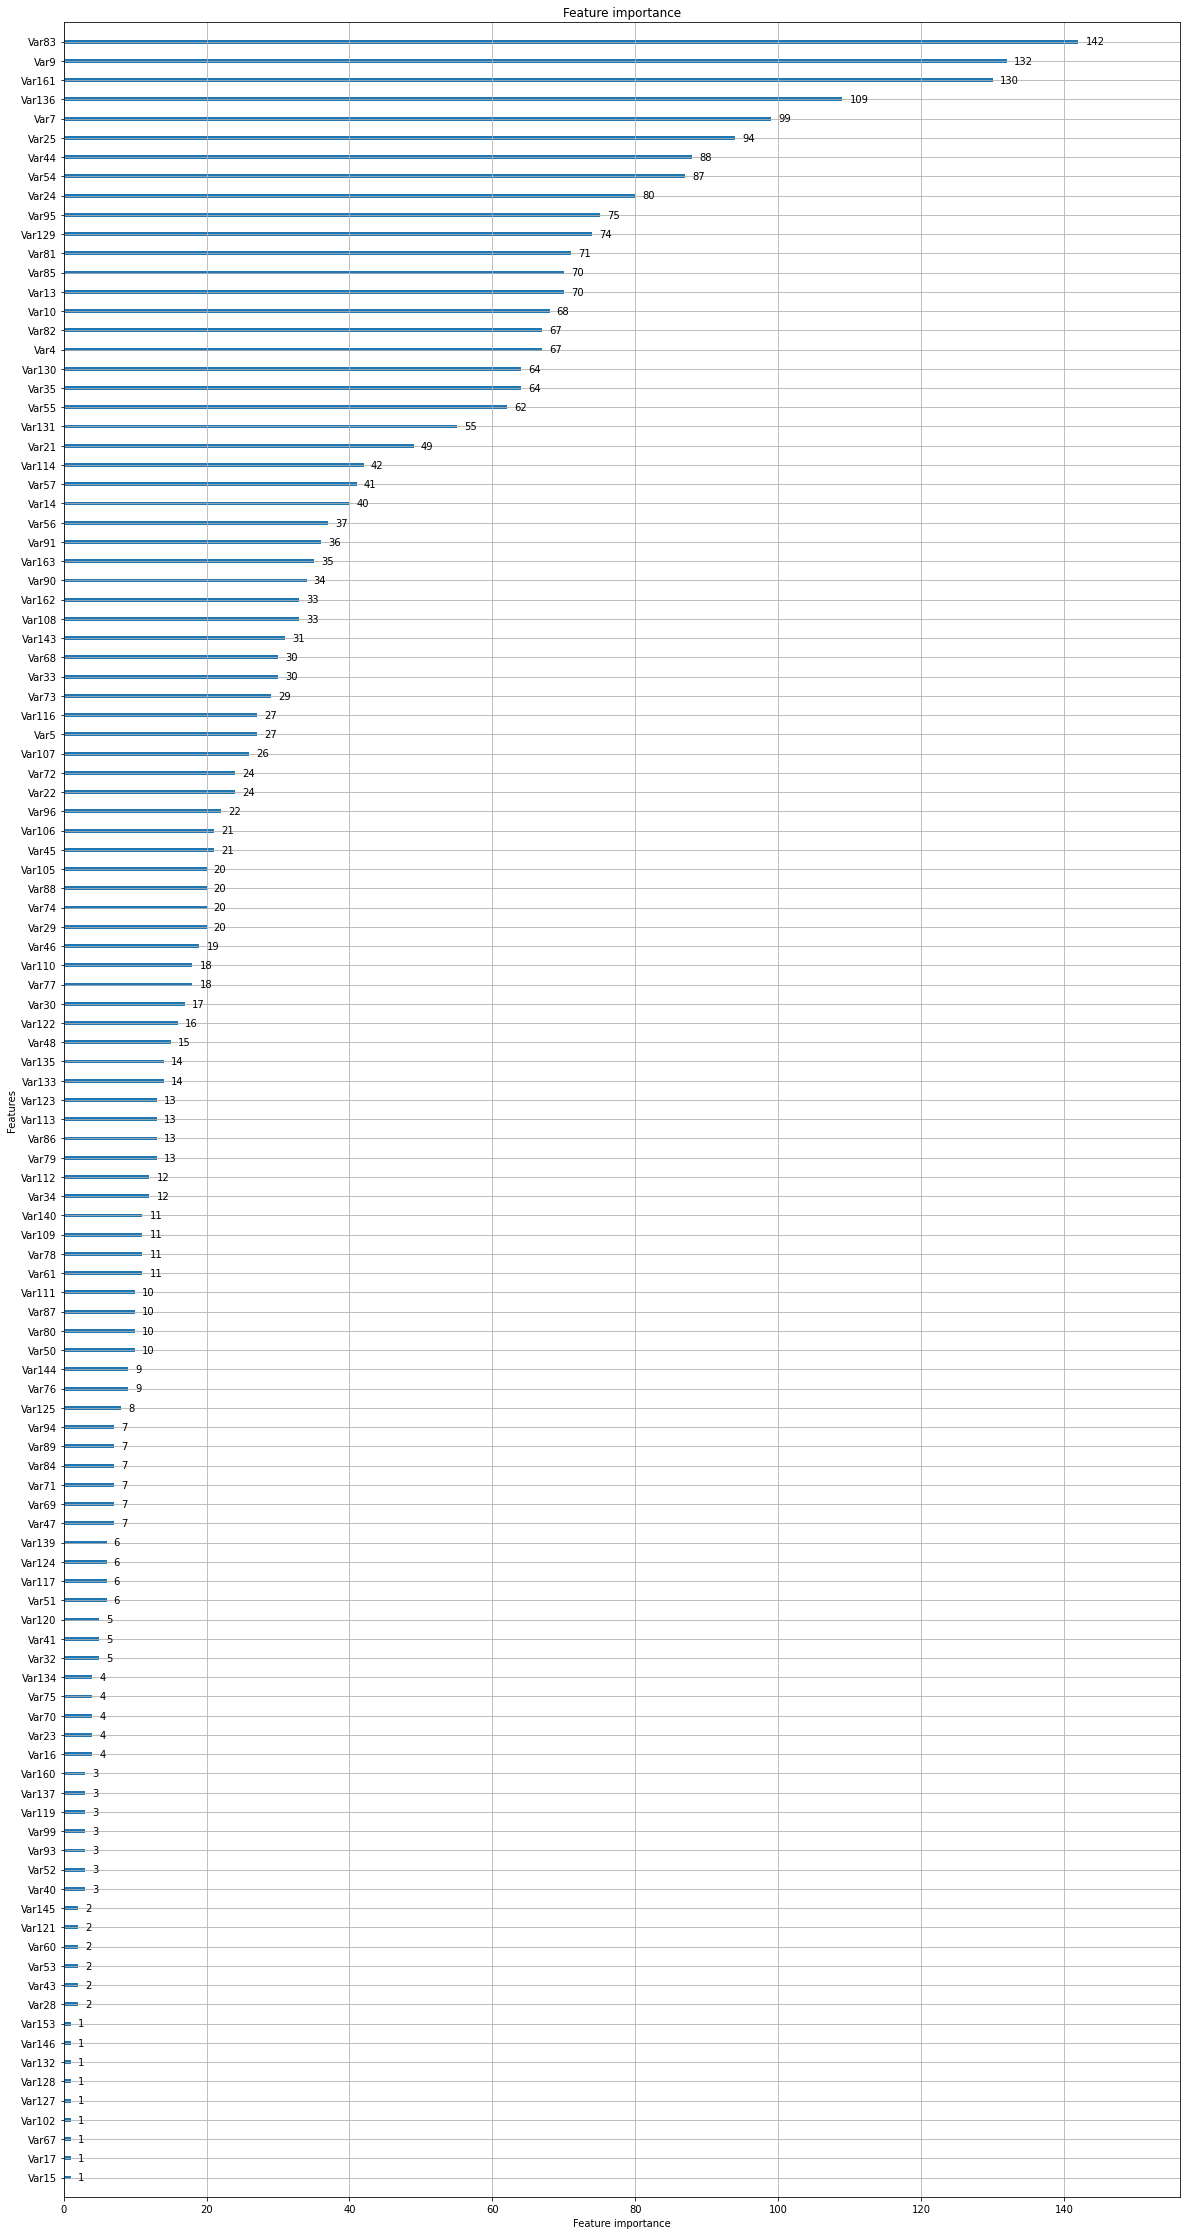

In [112]:
lgb.plot_importance(lgbm.best_estimator_['model'], figsize=(20, 40))

In [111]:
model = RandomForestClassifier(n_estimators=ESTIMATORS, class_weight='balanced_subsample')
pipe = Pipeline([('model', model)])
param_grid = {
    'model__min_samples_leaf': [20],
    'model__max_features': ['sqrt']
}
# Defaults to StratifiedKFold
rf = GridSearchCV(pipe, cv=FOLDS, param_grid=param_grid, scoring=SCORING)
rf.fit(x_train, y_train)
best_score = rf.best_score_
best_score_std = rf.cv_results_['std_test_score'][rf.best_index_]
print(f"""best params={repr(rf.best_params_)}
best score={best_score:0.3f}, std={best_score_std:0.3f}
""")
res = pd.DataFrame.from_dict(rf.cv_results_)
res.set_index('rank_test_score', inplace=True)
res.head()

best params={'model__max_features': 'sqrt', 'model__min_samples_leaf': 20}
best score=0.701, std=0.086



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__max_features,param_model__min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score
rank_test_score,,,,,,,,,,,,,,
1,0.702109,0.018574,0.021579,0.000945,sqrt,20,"{'model__max_features': 'sqrt', 'model__min_sa...",0.610115,0.597856,0.772705,0.812624,0.713977,0.701455,0.085636


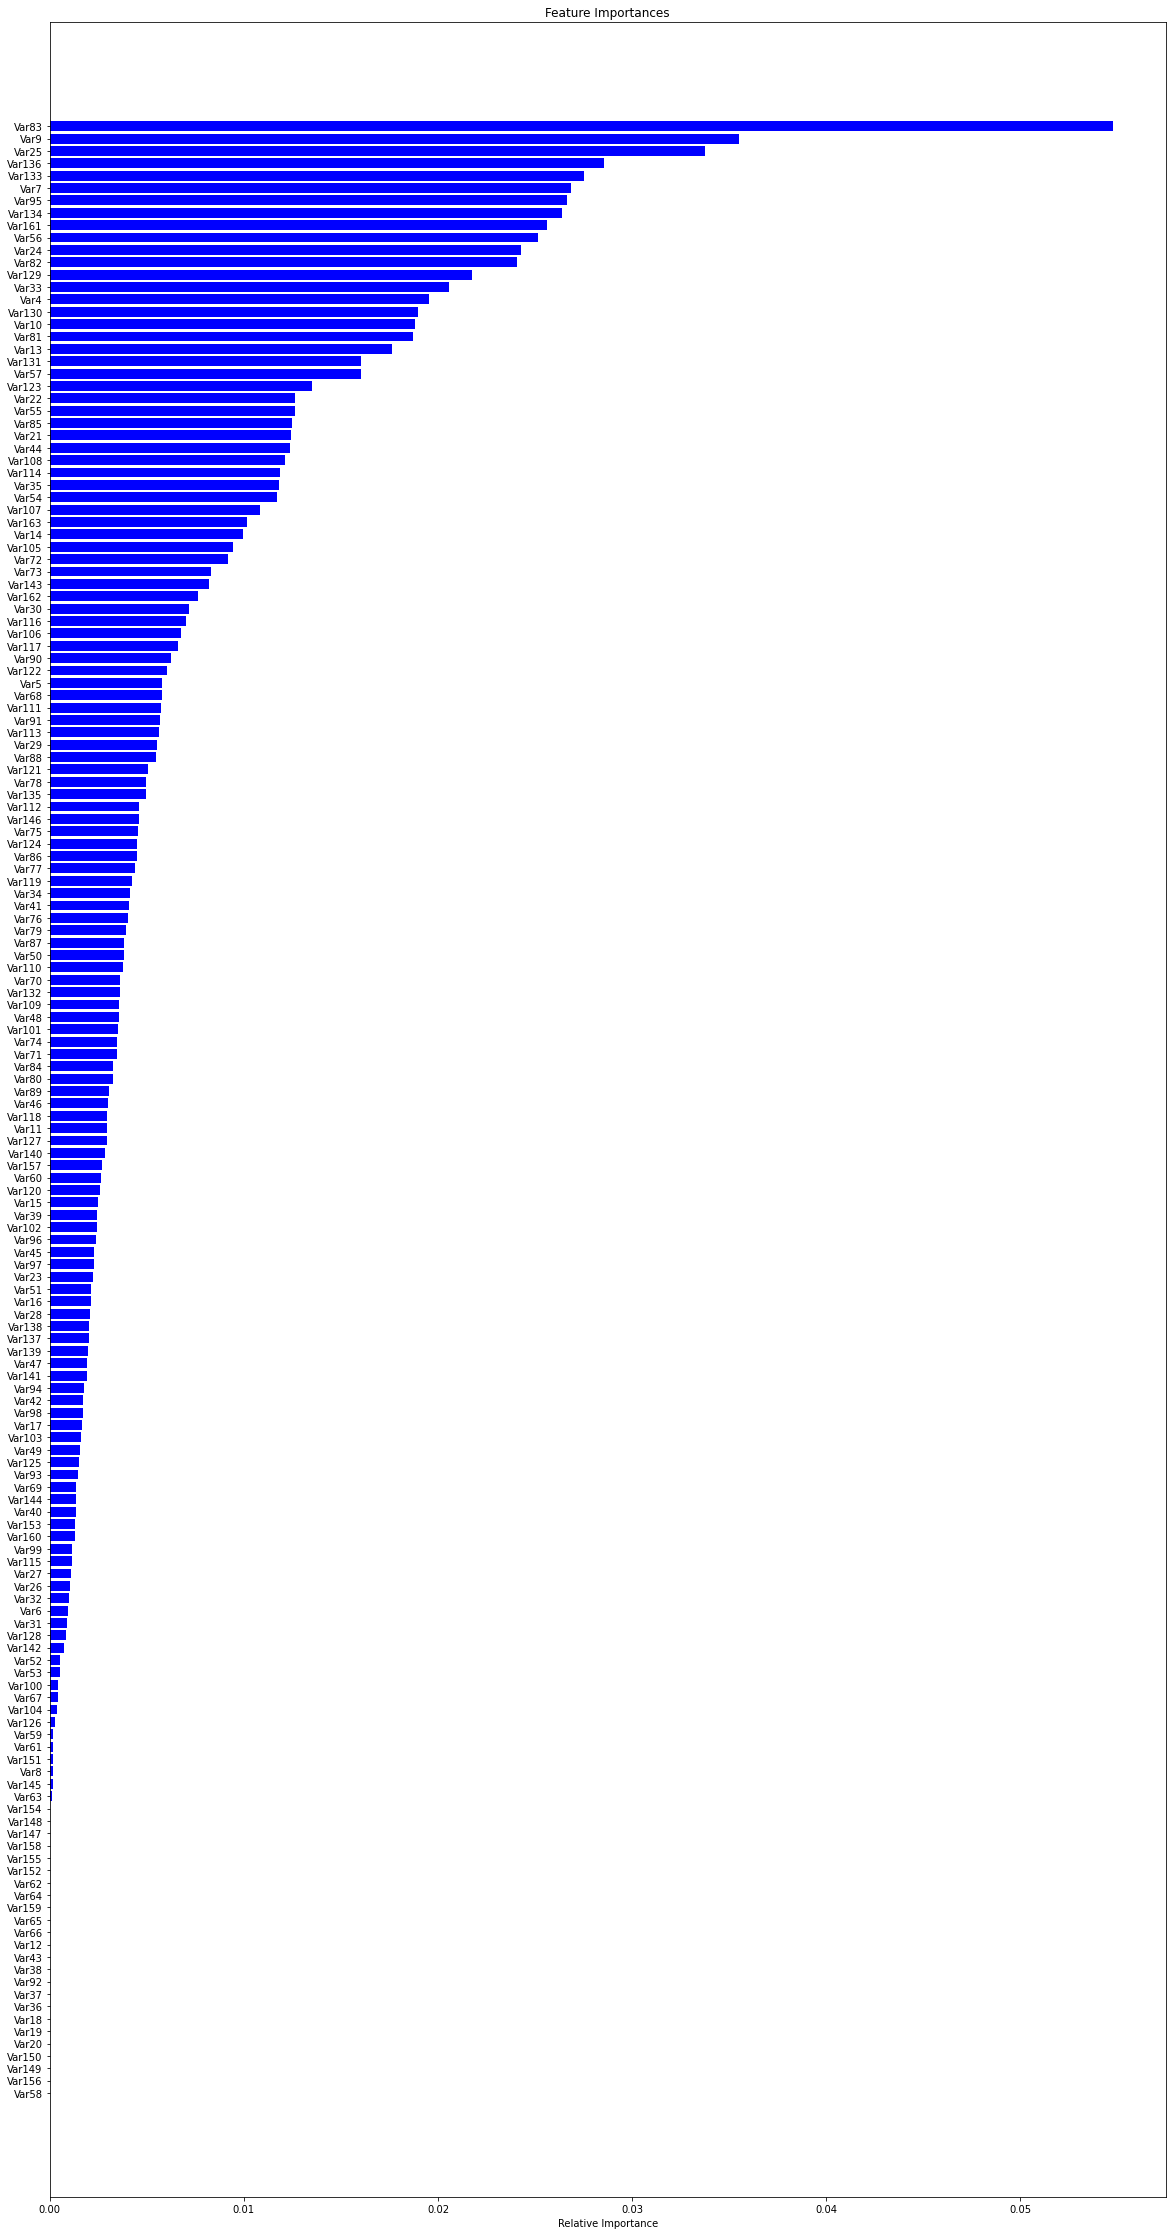

In [118]:
importances = rf.best_estimator_['model'].feature_importances_
plt.figure(figsize=(20,40))
plt.title("Feature importances")
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [FEATURES[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()